In [1]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


IBMQ.save_account('ad3965ae3913db06521d71bba9e1208319b91a9e7ab869744cd624d63a8e898cfef58312e0819dcc2a1a2ffa59a867a4fdf5f6e225c6f2c80f28e03d3bb1a61a',overwrite=True)

#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)

#IBMQ.save_account('676f27667e5b533a92387a7716d67080d9648d217e96873f767e3834c2861bd4590a7ffbff31002cbce3f215642436c9a2e3a731e24b797ed5acd92765a463c2',overwrite=True)
#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)



IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends() 

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
from qiskit import *

In [3]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [4]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [5]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)


n=1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
    
circuit = QuantumCircuit(qr, cr)
barriers = True


            # Apply Hadamard gate
circuit.h(qr)    
    

            # Apply Z-gate 
circuit.z(qr)  

            # Apply barrier 


            # Apply Hadamard gate
circuit.h(qr) 

            # Measure the register
    
for i in range(n):
    circuit.measure(qr[i], cr[i])

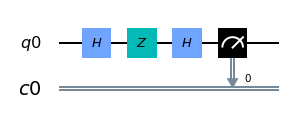

In [6]:
circuit.draw('mpl')

In [7]:
provider = IBMQ.get_provider(hub='ibm-q')
#device = provider.get_backend('ibmq_vigo')

In [8]:
FidelityFull1=[]
FidelityPartial1=[]
FidelityNoisy1=[]

JobIDFull1=[]
JobIDPartial1=[]
JobID_DJA1=[]

MatrixFull1=[]
MatrixPartial1=[]

In [15]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')
device = provider.get_backend('ibmq_5_yorktown')
bit='1'

for j in range (0,14):
    
    Trials=2**j  
    #Trials=8192
    
    job = execute(circuit, backend=device, shots=Trials)
    device_result = job.result()
    a=device_result.get_counts(circuit).get(bit)
    
    
    cal_job = execute(cal_circuits,
             backend=device,
             shots=Trials,
             optimization_level=0)
    #print(cal_job.job_id())

    cal_results = cal_job.result()

    index=2**n-1
    cal_job_partial = execute(cal_circuits[index],
             backend=device,
             shots=Trials,
             optimization_level=0)
    cal_results_partial = cal_job_partial.result()
    #JobIDPartial.append(cal_job_partial.job_id())
   
    meas_fitter = CompleteMeasFitter(cal_results, state_labels)
    meas_fitter_partial = CompleteMeasFitter(cal_results_partial, state_labels)
    for k in range (2**n-1):
        meas_fitter_partial.cal_matrix[k,k]=1
        
    
    meas_filter_partial =meas_fitter_partial.filter
    mitigated_result_partial = meas_filter_partial.apply(device_result)
    mitigated_counts_partial = mitigated_result_partial.get_counts(circuit)
    
    meas_filter =meas_fitter.filter
    mitigated_result = meas_filter.apply(device_result)
    mitigated_counts = mitigated_result.get_counts(circuit)
    
    FidelityNoisy1.append(device_result.get_counts(circuit).get(bit)/Trials)
    FidelityPartial1.append(mitigated_counts_partial.get(bit)/Trials)
    FidelityFull1.append(mitigated_counts.get(bit)/Trials)
    
    JobIDFull1.append("'"+str(cal_job.job_id())+"'")
    JobIDPartial1.append("'"+str(cal_job_partial.job_id())+"'")
    JobID_DJA1.append("'"+str(job.job_id())+"'")
    
    MatrixFull1.append(meas_fitter.cal_matrix)
    MatrixPartial1.append(meas_fitter_partial.cal_matrix)

In [16]:
def MatlabStr(array):
    return '[' + "; ".join(" ".join("%6g" % val for val in line) for line in array) + ']'

In [17]:
print(FidelityFull1)
print(FidelityPartial1)
print(FidelityNoisy1)

print(JobIDFull1)
print(JobIDPartial1)
print(JobID_DJA1)

print(MatrixFull1)
print(MatrixPartial1)

[1.0, 0.9999999999999998, 0.9999999999999998, 0.7499999999567736, 1.0, 0.9999999999999993, 0.965517241391804, 0.999999999999974, 0.9861751152004536, 0.9999999999982094, 0.9909194097497603, 0.9954519613357901, 0.9999999999999934, 1.0]
[0.3687440151945284, 1.0, 0.9999999999999984, 0.8571428573468585, 0.9999999999999999, 0.9999999999999664, 0.9999999999999867, 0.9590163934343358, 0.9870689655196289, 0.9978813554990384, 0.992553188381681, 0.9814520400585869, 0.9999999999999992, 0.9999999999999974]
[1.0, 1.0, 1.0, 0.75, 0.9375, 0.96875, 0.890625, 0.9140625, 0.89453125, 0.919921875, 0.9111328125, 0.904296875, 0.91162109375, 0.91552734375]
["'5f2b599f159e2600136cbc90'", "'5f2b5cdbfa2efe00139612fc'", "'5f2b5e920ca1ba0011b3d30d'", "'5f2b6079fa2efe0013961341'", "'5f2b63a9c79cc2001a3ac7ec'", "'5f2b65d7f0563e001a6cbbe9'", "'5f2b67a00927b800133f9831'", "'5f2b69740927b800133f9849'", "'5f2b6cd00ca1ba0011b3d3f8'", "'5f2b6eadcbff540019b42e72'", "'5f2b70a2fa2efe001396141f'", "'5f2b75225b470a00125d4733'"

# Here I put the full matrices

In [18]:
for j in MatrixFull1:
    print(MatlabStr(j))

[     1      0;      0      1]
[     1    0.5;      0    0.5]
[     1    0.5;      0    0.5]
[     1      0;      0      1]
[     1   0.25;      0   0.75]
[     1 0.09375;      0 0.90625]
[0.984375 0.078125; 0.015625 0.921875]
[0.960938 0.09375; 0.0390625 0.90625]
[0.941406 0.09375; 0.0585938 0.90625]
[0.917969 0.0957031; 0.0820312 0.904297]
[0.941406 0.0810547; 0.0585938 0.918945]
[0.950684 0.0917969; 0.0493164 0.908203]
[0.945068 0.09375; 0.0549316 0.90625]
[0.946411 0.0891113; 0.0535889 0.910889]


# Here the partial

In [19]:
for j in MatrixPartial1:
    print(MatlabStr(j))

[     1      1;      0      0]
[     1    0.5;      0    0.5]
[     1      0;      0      1]
[     1  0.125;      0  0.875]
[     1   0.25;      0   0.75]
[     1 0.09375;      0 0.90625]
[     1 0.109375;      0 0.890625]
[     1 0.046875;      0 0.953125]
[     1 0.09375;      0 0.90625]
[     1 0.078125;      0 0.921875]
[     1 0.0820312;      0 0.917969]
[     1 0.0786133;      0 0.921387]
[     1 0.0922852;      0 0.907715]
[     1 0.0875244;      0 0.912476]


In [2]:
A=[[[1., 0.],
       [0., 1.]], [[1. , 0.5],
       [0. , 0.5]], [[1. , 0.5],
       [0. , 0.5]], [[1., 0.],
       [0., 1.]], [[1.  , 0.25],
       [0.  , 0.75]], [[1.     , 0.09375],
       [0.     , 0.90625]], [[0.984375, 0.078125],
       [0.015625, 0.921875]], [[0.9609375, 0.09375  ],
       [0.0390625, 0.90625  ]], [[0.94140625, 0.09375   ],
       [0.05859375, 0.90625   ]], [[0.91796875, 0.09570312],
       [0.08203125, 0.90429688]], [[0.94140625, 0.08105469],
       [0.05859375, 0.91894531]], [[0.95068359, 0.09179688],
       [0.04931641, 0.90820312]], [[0.94506836, 0.09375   ],
       [0.05493164, 0.90625   ]], [[0.94641113, 0.08911133],
       [0.05358887, 0.91088867]]]


In [2]:
def MatlabStr(array):
    return  "       ".join(" ".join("%f" % float(val) for val in line) for line in array)
w=0
    
for j in A:
    
    if w==0:
        print(" % N="+str(2**w)+" shot")
    else:
        print(" % N="+str(2**w)+" shots")
    print(MatlabStr(j))
    w=w+1

 % N=1 shot
1.000000 0.000000       0.000000 1.000000
 % N=2 shots
1.000000 0.500000       0.000000 0.500000
 % N=4 shots
1.000000 0.500000       0.000000 0.500000
 % N=8 shots
1.000000 0.000000       0.000000 1.000000
 % N=16 shots
1.000000 0.250000       0.000000 0.750000
 % N=32 shots
1.000000 0.093750       0.000000 0.906250
 % N=64 shots
0.984375 0.078125       0.015625 0.921875
 % N=128 shots
0.960938 0.093750       0.039062 0.906250
 % N=256 shots
0.941406 0.093750       0.058594 0.906250
 % N=512 shots
0.917969 0.095703       0.082031 0.904297
 % N=1024 shots
0.941406 0.081055       0.058594 0.918945
 % N=2048 shots
0.950684 0.091797       0.049316 0.908203
 % N=4096 shots
0.945068 0.093750       0.054932 0.906250
 % N=8192 shots
0.946411 0.089111       0.053589 0.910889


In [ ]:

1.000000 0.000000 % N=1 shot
0.000000 1.000000

1.000000 0.500000 % N=2 shots
0.000000 0.500000

1.000000 0.500000 % N=4 shots
0.000000 0.500000

1.000000 0.000000 % N=8 shots
0.000000 1.000000

1.000000 0.250000 % N=16 shots
0.000000 0.750000

1.000000 0.093750 % N=32 shots
0.000000 0.906250

0.984375 0.078125 % N=64 shots 
0.015625 0.921875

0.960938 0.093750 % N=128 shots
0.039062 0.906250

0.941406 0.093750 % N=256 shots
0.058594 0.906250

0.917969 0.095703 % N=512 shots
0.082031 0.904297

0.941406 0.081055 % N=1024 shots
0.058594 0.918945

0.950684 0.091797 % N=2048 shots
0.049316 0.908203

0.945068 0.093750 % N=4096 shots
0.054932 0.906250

0.946411 0.089111 % N=8192 shots
0.053589 0.910889

In [3]:
B=[[[1., 1.],
       [0., 0.]], [[1. , 0.5],
       [0. , 0.5]], [[1., 0.],
       [0., 1.]], [[1.   , 0.125],
       [0.   , 0.875]], [[1.  , 0.25],
       [0.  , 0.75]], [[1.     , 0.09375],
       [0.     , 0.90625]], [[1.      , 0.109375],
       [0.      , 0.890625]], [[1.      , 0.046875],
       [0.      , 0.953125]], [[1.     , 0.09375],
       [0.     , 0.90625]], [[1.      , 0.078125],
       [0.      , 0.921875]], [[1.        , 0.08203125],
       [0.        , 0.91796875]], [[1.        , 0.07861328],
       [0.        , 0.92138672]], [[1.        , 0.09228516],
       [0.        , 0.90771484]], [[1.        , 0.08752441],
       [0.        , 0.91247559]]]

In [4]:
def MatlabStr(array):
    return  "       ".join(" ".join("%f" % float(val) for val in line) for line in array)
w=0
    
for j in B:
    
    if w==0:
        print(" % N="+str(2**w)+" shot")
    else:
        print(" % N="+str(2**w)+" shots")
    print(MatlabStr(j))
    w=w+1

 % N=1 shot
1.000000 1.000000       0.000000 0.000000
 % N=2 shots
1.000000 0.500000       0.000000 0.500000
 % N=4 shots
1.000000 0.000000       0.000000 1.000000
 % N=8 shots
1.000000 0.125000       0.000000 0.875000
 % N=16 shots
1.000000 0.250000       0.000000 0.750000
 % N=32 shots
1.000000 0.093750       0.000000 0.906250
 % N=64 shots
1.000000 0.109375       0.000000 0.890625
 % N=128 shots
1.000000 0.046875       0.000000 0.953125
 % N=256 shots
1.000000 0.093750       0.000000 0.906250
 % N=512 shots
1.000000 0.078125       0.000000 0.921875
 % N=1024 shots
1.000000 0.082031       0.000000 0.917969
 % N=2048 shots
1.000000 0.078613       0.000000 0.921387
 % N=4096 shots
1.000000 0.092285       0.000000 0.907715
 % N=8192 shots
1.000000 0.087524       0.000000 0.912476


In [ ]:

1.000000 1.000000 % N=1 shot
0.000000 0.000000

1.000000 0.500000 % N=2 shots
0.000000 0.500000

1.000000 0.000000 % N=4 shots
0.000000 1.000000

1.000000 0.125000 % N=8 shots
0.000000 0.875000

1.000000 0.250000 % N=16 shots
0.000000 0.750000

1.000000 0.093750 % N=32 shots
0.000000 0.906250

1.000000 0.109375 % N=64 shots
0.000000 0.890625

1.000000 0.046875 % N=128 shots
0.000000 0.953125

1.000000 0.093750 % N=256 shots
0.000000 0.906250

1.000000 0.078125 % N=512 shots
0.000000 0.921875

1.000000 0.082031 % N=1024 shots
0.000000 0.917969

1.000000 0.078613 % N=2048 shots
0.000000 0.921387

1.000000 0.092285 % N=4096 shots
0.000000 0.907715

1.000000 0.087524 % N=8192 shots
0.000000 0.912476

In [1]:
def stand7(w):
    if len(str(w))<9:
        return str(w)+(9-len(str(w)))*"0"  
    else:
        return str(w)[:9] 

def G7(A):
    logN=0
    for Matr in A:
        w=0
        for j in Matr:
            prnt=''
            for k in j:
                prnt=prnt+stand7(k)+" "
            if w==0:
                if logN==0:
                    prnt=prnt+"% N="+str(2**logN)+" shot"
                else:
                    prnt=prnt+"% N="+str(2**logN)+" shots"
            w=w+1
            print(prnt)
        logN=logN+1
        print('')

In [4]:
G7(A)

1.0000000 0.0000000 % N=1 shot
0.0000000 1.0000000 

1.0000000 0.5000000 % N=2 shots
0.0000000 0.5000000 

1.0000000 0.5000000 % N=4 shots
0.0000000 0.5000000 

1.0000000 0.0000000 % N=8 shots
0.0000000 1.0000000 

1.0000000 0.2500000 % N=16 shots
0.0000000 0.7500000 

1.0000000 0.0937500 % N=32 shots
0.0000000 0.9062500 

0.9843750 0.0781250 % N=64 shots
0.0156250 0.9218750 

0.9609375 0.0937500 % N=128 shots
0.0390625 0.9062500 

0.9414062 0.0937500 % N=256 shots
0.0585937 0.9062500 

0.9179687 0.0957031 % N=512 shots
0.0820312 0.9042968 

0.9414062 0.0810546 % N=1024 shots
0.0585937 0.9189453 

0.9506835 0.0917968 % N=2048 shots
0.0493164 0.9082031 

0.9450683 0.0937500 % N=4096 shots
0.0549316 0.9062500 

0.9464111 0.0891113 % N=8192 shots
0.0535888 0.9108886 



In [7]:
G7(B)

1.0000000 1.0000000 % N=1 shot
0.0000000 0.0000000 

1.0000000 0.5000000 % N=2 shots
0.0000000 0.5000000 

1.0000000 0.0000000 % N=4 shots
0.0000000 1.0000000 

1.0000000 0.1250000 % N=8 shots
0.0000000 0.8750000 

1.0000000 0.2500000 % N=16 shots
0.0000000 0.7500000 

1.0000000 0.0937500 % N=32 shots
0.0000000 0.9062500 

1.0000000 0.1093750 % N=64 shots
0.0000000 0.8906250 

1.0000000 0.0468750 % N=128 shots
0.0000000 0.9531250 

1.0000000 0.0937500 % N=256 shots
0.0000000 0.9062500 

1.0000000 0.0781250 % N=512 shots
0.0000000 0.9218750 

1.0000000 0.0820312 % N=1024 shots
0.0000000 0.9179687 

1.0000000 0.0786132 % N=2048 shots
0.0000000 0.9213867 

1.0000000 0.0922851 % N=4096 shots
0.0000000 0.9077148 

1.0000000 0.0875244 % N=8192 shots
0.0000000 0.9124755 

